# RL

## Learning to Optimize Rewards

In RL, a software agent makes observations and takes actions within an environment, and in return it receives rewards.  

## Policy Search

The algorithm a software agent uses to determine its actions is called its __policy__.  
The policy could be a NN taking observations as inputs and outputting the action to take.  

If policy involves randomness, it is called a _stochastic policy_.  

1) Genetic algorithms  
2) Policy gradients 

In [1]:
import gym
env = gym.make("CartPole-v1")
obs = env.reset()
print(obs)

[-0.02910841  0.01107512 -0.02014337 -0.01282661]


`obs = [x, x_velocity, angle, angular_velocity]`

In [5]:
def basic_policy(obs):
    angle = obs[2]
    return 0 if angle < 0 else 1

In [8]:
def run_basic_policy():
    totals = []
    for ep in range(500):
        ep_rewards = 0
        obs = env.reset()
        for step in range(200):
            env.render()
            action = basic_policy(obs)
            obs, reward, done, info = env.step(action)
            ep_rewards += reward
            if done:
                break
        totals.append(ep_rewards)
    return totals

In [9]:
totals = run_basic_policy()

In [3]:
np.mean(totals), np.std(totals), np.min(totals), np.max(totals)

NameError: name 'totals' is not defined

In [3]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

In [14]:
n_inputs = 4
model = keras.models.Sequential([
    keras.layers.Dense(5, activation='elu', input_shape=[n_inputs,]),
    keras.layers.Dense(1, activation='sigmoid')
])

## Credit assignment problem, discount factor $\gamma$

In [15]:
gamma = 0.9

In [16]:
def play_one_step(env, obs, model, loss_fn):
    with tf.GradientTape() as tape:
        left_proba = model(obs[np.newaxis])
        action = (tf.random.uniform([1,1]) > left_proba)
        y_target = tf.constant([[1.]]) - tf.cast(action, tf.float32)
        loss = tf.reduce_mean(loss_fn(y_target, left_proba))
    grads = tape.gradient(loss, model.trainable_variables)
    obs, reward, done, info = env.step(int(action[0,0].numpy()))
    return obs, reward, done, grads

In [17]:
def play_multiple_episodes(env, n_episodes, n_max_steps, model, loss_fn):
    all_rewards = []
    all_grads = []
    for episode in range(n_episodes):
        current_rewards = []
        current_grads = []
        obs = env.reset()
        for step in range(n_max_steps):
            obs, reward, done, grads = play_one_step(env, obs, model, loss_fn)
            current_rewards.append(reward)
            current_grads.append(grads)
            if done:
                break
        all_rewards.append(current_rewards)
        all_grads.append(current_grads)
    return all_rewards, all_grads

In [18]:
def discount_rewards(rewards, discount_factor):
    discounted = np.array(rewards)
    for step in range(len(rewards) - 2, -1, -1):
        discounted[step] += discounted[step + 1] * discount_factor
    return discounted

def discount_and_normalize_rewards(all_rewards, discount_factor):
    all_discounted_rewards = [discount_rewards(rewards, discount_factor) for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean) / reward_std for discounted_rewards in all_discounted_rewards]

In [19]:
discount_rewards([10, 0, -50], discount_factor=0.8)

array([-22, -40, -50])

In [20]:
discount_and_normalize_rewards([[10, 0, -50], [10, 20]], discount_factor=0.8)

[array([-0.28435071, -0.86597718, -1.18910299]),
 array([1.26665318, 1.0727777 ])]

In [21]:
n_iterations = 150
n_episodes_per_update = 10
n_max_steps = 200
discount_factor = 0.95

In [22]:
optimizer = keras.optimizers.Adam(lr=0.01)
loss_fn = keras.losses.binary_crossentropy

In [ ]:
from tqdm.notebook import tqdm


In [29]:
def train():
    for iter in range(n_iterations):
        all_rewards, all_grads = play_multiple_episodes(env, n_episodes_per_update, n_max_steps, model, loss_fn)
        all_final_rewards = discount_and_normalize_rewards(all_rewards, discount_factor)
        
        all_mean_grads = []
        for vi in range(len(model.trainable_variables)):
            mean_grads = tf.reduce_mean([final_reward * all_grads[episode_index][step][vi] 
             for episode_index, final_rewards in enumerate(all_final_rewards) 
                 for step, final_reward in enumerate(final_rewards)], axis=0)
            all_mean_grads.append(mean_grads)
        optimizer.apply_gradients(zip(all_mean_grads, model.trainable_variables))

In [30]:
train()

In [46]:
import time
def test():
    obs = env.reset()
    done = False
    while not done:
        time.sleep(0.05)
        env.render()
        action = model(obs[np.newaxis])
        obs, reward, done, _ = env.step(int(action[0,0].numpy()))

In [47]:
test()

In [48]:
env.close()

# Markov Decision Process

## Bellman Optimality Equation

Bellman fount a way to estimate the _optimal state_ value of any state $s$, noted $V^*(s)$, which is the sum of all discounted future rewards the agent can expect on average after it reaches a state s, assuming it acts optimally.  
This recursive equation says that if the agent acts optimally, then the optimal value of the current state is equal to the reward it will get on average after taking one optimal action, plus the expected optimal value of all possible next states that this action can lead to.  


$V^*(s) = max_a \sum_s T(s,a,s') \left[R(s, a, s') + \gamma V^*(s') \right] \text{  for all s}$

### Value Iteration algorithm

$V_{k+1}(s) \leftarrow max_a \sum_{s'} T(s,a,s') \left[ R(s,a,s') + \gamma V_k(s') \right] \text {   for all s}$

# Q-values (Quality Values)
State-action values (Q-Values).  The optimal Q-Value of the state-action pair (s,a) noted $Q^*(s,a)$, is the sum of discounted future rewards tha gent can expect on average after it reaches the state s and chooses action a, but before it sees the outcome of this action, assuming it acts optimally after that action.  

Start with initialization all the Q-Value estimates to zero, then you update them using the Q-Value Iteration algorthm  
$Q_{k+1}(s,a) \leftarrow \sum_{s'}T(s,a,s')\left[ R(s,a,s') + \gamma max_{a'} Q_k(s',a') \right]$   

Thus Optimal Policy $\pi^*(s) = argmax_a Q^*(s,a)$

In [4]:
gamma = 0.90 # the discount factor

transition_probabilities = [ # shape=[s, a, s']
    [[0.7, 0.3, 0.0], [1.0, 0.0, 0.0], [0.8, 0.2, 0.0]],
    [[0.0, 1.0, 0.0], None, [0.0, 0.0, 1.0]],
    [None, [0.8, 0.1, 0.1], None]]
rewards = [ # shape=[s, a, s']
    [[+10, 0, 0], [0, 0, 0], [0, 0, 0]],
    [[0, 0, 0], [0, 0, 0], [0, 0, -50]],
    [[0, 0, 0], [+40, 0, 0], [0, 0, 0]]]
possible_actions = [[0, 1, 2], [0, 2], [1]]

Q_values = np.full((3, 3), -np.inf) # -np.inf for impossible actions
for state, actions in enumerate(possible_actions):
    Q_values[state, actions] = 0.0 # for all possible actions

for iteration in range(50):
    Q_prev = Q_values.copy()
    for s in range(3):
        for a in possible_actions[s]:
            Q_values[s, a] = np.sum([transition_probabilities[s][a][sp] * (rewards[s][a][sp] + gamma * np.max(Q_prev[sp]))
                for sp in range(3)])

In [50]:
np.argmax(Q_values, axis=1)

array([0, 0, 1])

# Temporal Difference Learning

RL problems with discrete actions can often be modeled as Markov decision processes, but the agnet initially has no idea what the transition probabilities are, and it does not know what the rewards are going to be iether. it must experience each state and each transition at least once to know the rewards, and it must experience them multiple times if it is to have a reasonable estimate of the transition probabilities.  

The _Temporal Difference Learning_ (TD Learning) algorithm is very similar to the Value Iteration algorithm, but tweaked to make into account the fact that the agent has only partial knowledge of the MDP. In general we assume that  the agent initially knows only the possible states and actions, and nothing more. The agent uses and _exploration policy_ - for example, a purely random policy - to explore the MDP, and as it progresses, the TD Learning algorithm updates the estimates of the state values based on the transitions and rewards athat are actually observed.  

$V_{k+1}(s) \leftarrow V_k(s) + \alpha \delta_k(s,r,s')$  
$\delta_k(s,r,s') = r + \gamma V_k(s') - V_k(s)$

- $\alpha$ - learning rate (0.01)  
- $r + \gamma V_k(s')$ is called the TD _target_  
- $\delta_k(s,r,s')$ is called the TD _error_  


For each state s, this algorithm simply keeps track of a running average of the immediate rewards the agnet gets upon leaving that state, plus the rewards it expects to get later (assuming it acts optimally).  

# Q-Learning

Adaptation of the Q-Value Iteration algorithm, where the transition probabilities and the rewards are initially unknown.  
$Q(s,a) \leftarrow_\alpha r + \gamma \max_{a'}Q(s',a')$  

For each state-action pair (s,a), this algorithm keeps track of a runnning average of the rewards r the agent gets upon leaving the state s with action a, plut the sum of discounted future rewards it expects to get. To estimate this sum, we take the maximum of the Q-Value estimates for the next state s', since we assume that the target policy would act optimally from then on.  

In [5]:
def step(state, action):
    probas = transition_probabilities[state][action]
    next_state = np.random.choice([0,1,2], p=probas)
    reward = rewards[state][action][next_state]
    return next_state, reward

def exploration_policy(state):
    return np.random.choice(possible_actions[state])

In [6]:
alpha0 = 0.05
decay = 0.005
gamma = 0.9
state = 0

for iteration in range(10000):
    action = exploration_policy(state)
    next_state, reward = step(state, action)
    next_value = np.max(Q_values[next_state])
    alpha = alpha0 / (1+iteration * decay)
    Q_values[state, action] *= 1 - alpha
    Q_values[state, action] += alpha * (reward + gamma * next_value)
    state = next_state

# Off-policy vs On-policy algorithm

An algorithm is called _off-policy_ if the policy being trained is not necessarily the one being executed.  
Policy Gradients algorithm is _on-policy_ algorithm: it explores the world using the policy being trained.  

# Exploration Policies

$\epsilon$_-greedy policy_ (act randomly with probability $\epsilon$, or 1-$\epsilon$ take the highest Q-Value)  

$Q(s,a) \leftarrow_\alpha r + \gamma max_{a'} f(Q(s',a'), N(s',a'))$  
- $N(s',a')$ counts the number of times the action a' was chisen in state s'
- $f(Q,N)$ is an exploration function, such as $f(Q,N) = Q + k/(1+N)$, k is a curiosity hyperparameter.  

In [4]:
env = gym.make('CartPole-v0')
input_shape = [4]

n_outputs = 2

model = keras.models.Sequential([
    keras.layers.Dense(32, activation='elu', input_shape=input_shape),
    keras.layers.Dense(32, activation='elu'),
    keras.layers.Dense(n_outputs)
])

In [5]:
def epsilon_greedy_policy(state, epsilon=0):
    if np.random.rand() < epsilon:
        return np.random.randint(2)
    else:
        Q_values = model.predict(state[np.newaxis])
        return np.argmax(Q_values[0])

In [7]:
from collections import deque
import random

replay_buffer = deque(maxlen=2000)

In [16]:
def sample_experiences(batch_size):
    items = random.sample(replay_buffer, batch_size)
    s, a, r, ns, d = zip(*items)
    return map(np.array, [s, a, r, ns, d])

In [17]:
def play_one_step(env, state, epsilon):
    action = epsilon_greedy_policy(state, epsilon)
    ns, r, d, i = env.step(action)
    replay_buffer.append((state, action, r, ns, d))
    return ns, r, d, i

In [20]:
batch_size = 32
discount_factor = 0.95
optimizer = keras.optimizers.Adam(lr=1e-3)
loss_fn = keras.losses.mean_squared_error

def training_step(batch_size):
    states, actions, rewards, new_states, dones = sample_experiences(batch_size)
    next_Q_values = model.predict(new_states)
    max_next_Q_values = np.max(next_Q_values, axis=1)
    target_Q_values = (rewards + (1-dones) * discount_factor * max_next_Q_values)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [25]:
rewards = []

for episode in range(600):
    obs = env.reset()
    for step in range(200):
        epsilon = max(1. - episode / 500., 0.01)
        obs, r, d, i = play_one_step(env, obs, epsilon)
        if d:
            rewards.append(step)
            break
    if episode > 50:
        training_step(batch_size)

In [36]:
import pandas as pd

In [41]:
rewards = np.array(rewards)
rewards = pd.Series(rewards)
means = rewards.rolling(50).mean()

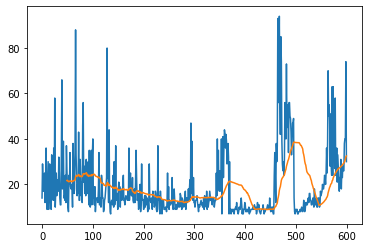

In [43]:
import matplotlib.pyplot as plt

plt.plot(range(0, len(rewards)), rewards)
plt.plot(range(len(rewards) - len(means), len(rewards)), means)
plt.show()

### Sudden drops on a plot is called `Catastrophic forgetting`

# Deep Q-Learning variants

## Fixed Q-Value networks

Tandem of `online` and `target` networks: `target` network makes predictions and `online` is learning. Each `k` episodes weights of target network are updated.  

## Double DQN

DeepMind researchers tweaked their DQN algorithm,
increasing its performance and somewhat stabilizing training. They called this
variant Double DQN. The update was based on the observation that the target
network is prone to overestimating Q-Values. Indeed, suppose all actions are
equally good: the Q-Values estimated by the target model should be identical,
but since they are approximations, some may be slightly greater than others, by
pure chance. The target model will always select the largest Q-Value, which will
be slightly greater than the mean Q-Value, most likely overestimating the true QValue
(a bit like counting the height of the tallest random wave when measuring
the depth of a pool). To fix this, they proposed using the online model instead of
the target model when selecting the best actions for the next states, and using the
target model only to estimate the Q-Values for these best actions.

In [44]:
def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones = experiences
    next_Q_values = model.predict(next_states)
    best_next_actions = np.argmax(next_Q_values, axis=1)
    next_mask = tf.one_hot(best_next_actions, n_outputs).numpy()
    next_best_Q_values = (target.predict(next_states) * next_mask).sum(axis=1)
    target_Q_values = (rewards + (1 - dones) * discount_factor * next_best_Q_values)
    mask = tf.one_hot(actions, n_outputs)
    [...] # the rest is the same as earlier

## Prioritized Experience Replay

Instead of sampling experiences uniformly from the replay buffer, why not
sample important experiences more frequently? This idea is called importance
sampling (IS) or prioritized experience replay (PER), and it was introduced in a
2015 paper by DeepMind researchers (once again!).  

More specifically, experiences are considered “important” if they are likely to
lead to fast learning progress. But how can we estimate this? One reasonable
approach is to measure the magnitude of the TD error δ = r + γ·V(s′) – V(s). A
large TD error indicates that a transition (s, r, s′) is very surprising, and thus
probably worth learning from. When an experience is recorded in the replay
buffer, its priority is set to a very large value, to ensure that it gets sampled at
least once. However, once it is sampled (and every time it is sampled), the TD
error δ is computed, and this experience’s priority is set to p = |δ| (plus a small
constant to ensure that every experience has a non-zero probability of being
sampled). The probability P of sampling an experience with priority p is
proportional to p , where ζ is a hyperparameter that controls how greedy we
want importance sampling to be: when ζ = 0, we just get uniform sampling, and
when ζ = 1, we get full-blown importance sampling. In the paper, the authors
used ζ = 0.6, but the optimal value will depend on the task.  

## Dueling DQN

The Dueling DQN algorithm (DDQN, not to be confused with Double DQN,
although both techniques can easily be combined) was introduced in yet another
2015 paper by DeepMind researchers. To understand how it works, we must
first note that the Q-Value of a state-action pair (s, a) can be expressed as Q(s, a)
= V(s) + A(s, a), where V(s) is the value of state s and A(s, a) is the advantage of
taking the action a in state s, compared to all other possible actions in that state.
Moreover, the value of a state is equal to the Q-Value of the best action a for
that state (since we assume the optimal policy will pick the best action), so V(s)
= Q(s, a ), which implies that A(s, a ) = 0. In a Dueling DQN, the model
estimates both the value of the state and the advantage of each possible action.
Since the best action should have an advantage of 0, the model subtracts the
maximum predicted advantage from all predicted advantages.  

